In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB:
    %pip install -q -U tensorflow-addons
    %pip install -q -U transformers

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


# Char-RNN

## Splitting a sequence into batches of shuffled windows

For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., `[2, 3, 4, 5, 6]` would be split into `[[2, 3, 4, 5], [3, 4, 5, 6]]`), then create batches of 3 such input/target pairs:

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


## Loading the Data and Preparing the Dataset

In [3]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [4]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [5]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [6]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [7]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [8]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [9]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [10]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

**Note**: in previous versions of this code, we used `dataset.repeat()` now to make the dataset "infinite", and later in the notebook we set the `steps_per_epoch` argument when calling the `model.fit()` method. This was needed to work around some TensorFlow bugs. However, since these bugs have now been fixed, we can simplify the code: no need for `dataset.repeat()` or `steps_per_epoch` anymore.

In [11]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

In [12]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [15]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [16]:
dataset = dataset.prefetch(1)

In [17]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Creating and Training the Model

**Warning**: the following code may take up to 24 hours to run, depending on your hardware. If you use a GPU, it may take just 1 or 2 hours, or less.

**Note**: the `GRU` class will only use the GPU (if you have one) when using the default values for the following arguments: `activation`, `recurrent_activation`, `recurrent_dropout`, `unroll`, `use_bias` and `reset_after`. This is why I commented out `recurrent_dropout=0.2` (compared to the book).

In [18]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     #recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     #recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=10)

Epoch 1/10
31368/31368 [==============================] - 2918s 93ms/step - loss: 1.6206
Epoch 2/10
31368/31368 [==============================] - 2889s 92ms/step - loss: 1.5369
Epoch 3/10
31368/31368 [==============================] - 3425s 109ms/step - loss: 1.5174
Epoch 4/10
31368/31368 [==============================] - 3236s 103ms/step - loss: 1.5059
Epoch 5/10
31368/31368 [==============================] - 3287s 105ms/step - loss: 1.4984
Epoch 6/10
31368/31368 [==============================] - 3029s 97ms/step - loss: 1.4931
Epoch 7/10
31368/31368 [==============================] - 3081s 98ms/step - loss: 1.4895
Epoch 8/10
31368/31368 [==============================] - 2861s 91ms/step - loss: 1.4867
Epoch 9/10
31368/31368 [==============================] - 2899s 92ms/step - loss: 1.4845
Epoch 10/10
31368/31368 [==============================] - 2960s 94ms/step - loss: 1.4824


## Using the Model to Generate Text

In [19]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

**Warning**: the `predict_classes()` method is deprecated. Instead, we must use `np.argmax(model(X_new), axis=-1)`.

In [20]:
X_new = preprocess(["How are yo"])
#Y_pred = model.predict_classes(X_new)
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

In [21]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 2, 1,
        0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2]],
      dtype=int64)

In [22]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [23]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

In [24]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [25]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

there i should be to the chaster
to make a baptista


In [26]:
print(complete_text("t", temperature=1))

this verier,
and i'll perck it in our doiel to your


In [27]:
print(complete_text("t", temperature=2))

th no fmepuless.; rebea cintp a blay o
baptistom's'


## Stateful RNN

In [28]:
tf.random.set_seed(42)

In [29]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [30]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

**Note**: once again, I commented out `recurrent_dropout=0.2` (compared to the book) so you can get GPU acceleration (if you have one).

In [31]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2,
                     dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [32]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [33]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=50,
                    callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 29s 86ms/step - loss: 2.6200
Epoch 2/50
313/313 [==============================] - 27s 86ms/step - loss: 2.2410
Epoch 3/50
313/313 [==============================] - 30s 96ms/step - loss: 2.1105
Epoch 4/50
313/313 [==============================] - 28s 88ms/step - loss: 2.0368
Epoch 5/50
313/313 [==============================] - 27s 85ms/step - loss: 1.9860 2s - loss: 1 - E
Epoch 6/50
313/313 [==============================] - 26s 84ms/step - loss: 1.9488
Epoch 7/50
313/313 [==============================] - 25s 81ms/step - loss: 1.9205
Epoch 8/50
313/313 [==============================] - 26s 82ms/step - loss: 1.8985
Epoch 9/50
313/313 [==============================] - 26s 82ms/step - loss: 1.8797
Epoch 10/50
313/313 [==============================] - 26s 84ms/step - loss: 1.8655
Epoch 11/50
313/313 [==============================] - 26s 82ms/step - loss: 1.8533
Epoch 12/50
313/313 [==============================] - 26s 82ms/step

To use the model with different batch sizes, we need to create a stateless copy. We can get rid of dropout since it is only used during training:

In [34]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

To set the weights, we first need to build the model (so the weights get created):

In [35]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [36]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [37]:
tf.random.set_seed(42)

print(complete_text("t"))

timins
as eye your city blood have dis, him.
pear n


# Sentiment Analysis

In [38]:
tf.random.set_seed(42)

You can load the IMDB dataset easily:

In [39]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

In [40]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [41]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

'<sos> this film was just brilliant casting location scenery story'

In [42]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

In [43]:
datasets.keys()

dict_keys(['train', 'test', 'unsupervised'])

In [44]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [45]:
train_size, test_size

(25000, 25000)

In [46]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



In [47]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [48]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [49]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [50]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [51]:
len(vocabulary)

53893

In [52]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [53]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [54]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [55]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]], dtype=int64)>

In [56]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [57]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


In [58]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 66s 77ms/step - loss: 0.5305 - accuracy: 0.7281
Epoch 2/5
782/782 [==============================] - 60s 77ms/step - loss: 0.3459 - accuracy: 0.8549
Epoch 3/5
782/782 [==============================] - 59s 75ms/step - loss: 0.1934 - accuracy: 0.9314
Epoch 4/5
782/782 [==============================] - 59s 75ms/step - loss: 0.1360 - accuracy: 0.9503
Epoch 5/5
782/782 [==============================] - 59s 75ms/step - loss: 0.1032 - accuracy: 0.9634


Or using manual masking:

In [59]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 66s 76ms/step - loss: 0.5425 - accuracy: 0.7156
Epoch 2/5
782/782 [==============================] - 59s 76ms/step - loss: 0.3481 - accuracy: 0.8548
Epoch 3/5
782/782 [==============================] - 59s 76ms/step - loss: 0.1759 - accuracy: 0.9378
Epoch 4/5
782/782 [==============================] - 59s 76ms/step - loss: 0.1232 - accuracy: 0.9562
Epoch 5/5
782/782 [==============================] - 59s 76ms/step - loss: 0.1103 - accuracy: 0.9588


## Reusing Pretrained Embeddings

In [60]:
tf.random.set_seed(42)

In [61]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [63]:
#import tensorflow_hub as hub

#model = keras.Sequential([
#    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
#                   dtype=tf.string, input_shape=[], output_shape=[50]),
#    keras.layers.Dense(128, activation="relu"),
#    keras.layers.Dense(1, activation="sigmoid")
#])
#model.compile(loss="binary_crossentropy", optimizer="adam",
#              metrics=["accuracy"])

In [64]:
#for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
#    for filename in filenames:
#        print(os.path.join(dirpath, filename))

In [65]:
#import tensorflow_datasets as tfds

#datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
#train_size = info.splits["train"].num_examples
#batch_size = 32
#train_set = datasets["train"].batch(batch_size).prefetch(1)
#history = model.fit(train_set, epochs=5)

## Automatic Translation

In [66]:
tf.random.set_seed(42)

In [67]:
vocab_size = 100
embed_size = 10

In [68]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

In [69]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [70]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 7s 137ms/step - loss: 4.6054
Epoch 2/2
32/32 [==============================] - 4s 132ms/step - loss: 4.6031


### Bidirectional Recurrent Layers

In [71]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


### Positional Encoding

In [72]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [73]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

Saving figure positional_embedding_plot


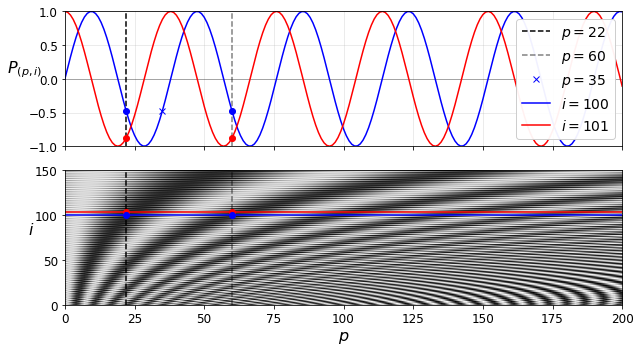

In [74]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
save_fig("positional_embedding_plot")
plt.show()

In [75]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

Here is a (very) simplified Transformer (the actual architecture has skip connections, layer norm, dense nets, and most importantly it uses Multi-Head Attention instead of regular Attention):

In [76]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

Here's a basic implementation of the `MultiHeadAttention` layer. One will likely be added to `keras.layers` in the near future. Note that `Conv1D` layers with `kernel_size=1` (and the default `padding="valid"` and `strides=1`) is equivalent to a `TimeDistributed(Dense(...))` layer.

In [77]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [78]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape

TensorShape([2, 50, 512])